In [1]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from geopy.distance import great_circle
from shapely.geometry import Point, LineString, MultiPoint, MultiLineString
import pdb
from ipyleaflet import Map, GeoJSON
import json

df = pd.read_csv('data/wroclaw/locations.csv')
print('Number of points:', len(df))
ax = sns.scatterplot(x=df.Longitude, y=df.Latitude, data=df)

Number of points: 5000


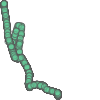

In [2]:
# Plot as Shapely MultiPoint
coords = df.loc[:, ['Latitude', 'Longitude']].values
MultiPoint(coords)

In [3]:
# Find cluster centers with DBSCAN (centers not in dataset)
kms_per_radian = 6371.0088
epsilon = 0.03 / kms_per_radian
db = DBSCAN(eps=epsilon, min_samples=10, algorithm='ball_tree', metric='haversine').fit(np.radians(coords))
print(type(db.components_))
max_label = max(db.labels_)
clusters = [coords[db.labels_ == label] for label in range(max_label)]
clusters = [c for c in clusters if c.shape[0] > 0]
print('Number of clusters:', len(clusters))

<class 'numpy.ndarray'>
Number of clusters: 54


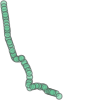

In [4]:
# Find most central point in each cluster (points in dataset)
def get_centermost_point(cluster):
    centroid = MultiPoint(cluster).centroid
    centroid = (centroid.x, centroid.y)
    most_central = min(cluster, key=lambda point: great_circle(point, centroid).m)
    return most_central

centers = [get_centermost_point(c) for c in clusters]
centers = np.array(centers).copy()

MultiPoint(centers)
#route = LineString(centers)
#route


In [5]:
# This is how you make a Leaflet map in Jupyter notebook (doesn't work in lab)
# Not used for anything here.
wroclaw_center = [51.114290, 17.033722]
m = Map(center=wroclaw_center, zoom=12)

"""
with open('data/wroclaw/locations.json') as f:
    data = json.load(f)

geo_json = GeoJSON(data=data)
m.add_layer(geo_json);
"""

m


Map(basemap={'url': 'https://{s}.tile.openstreetmap.org/{z}/{x}/{y}.png', 'max_zoom': 19, 'attribution': 'Map data (c) <a href="https://openstreetmap.org">OpenStreetMap</a> contributors'}, center=[51.11429, 17.033722], layers=(TileLayer(base=True, max_zoom=19, min_zoom=1, options=['attribution', 'detect_retina', 'max_zoom', 'min_zoom', 'tile_size']),), options=['attribution_control', 'basemap', 'bounce_at_zoom_limits', 'box_zoom', 'center', 'close_popup_on_click', 'double_click_zoom', 'dragging', 'inertia', 'inertia_deceleration', 'inertia_max_speed', 'interpolation', 'keyboard', 'keyboard_pan_offset', 'keyboard_zoom_offset', 'max_zoom', 'min_zoom', 'scroll_wheel_zoom', 'tap', 'tap_tolerance', 'touch_zoom', 'world_copy_jump', 'zoom', 'zoom_animation_threshold', 'zoom_control', 'zoom_start'])

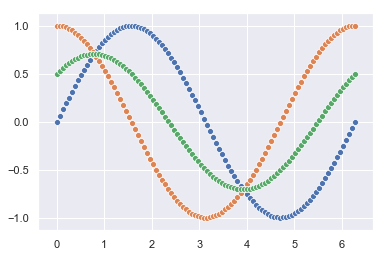

In [6]:
# How to average two curves
x = np.linspace(0, 2*np.pi, 100)
f = np.sin(x)
g = np.cos(x)
h = [(f[j] + g[j])/2 for j in range(len(x))] 

sns.scatterplot(x=x, y=f)
sns.scatterplot(x=x, y=g)
sns.scatterplot(x=x, y=h)

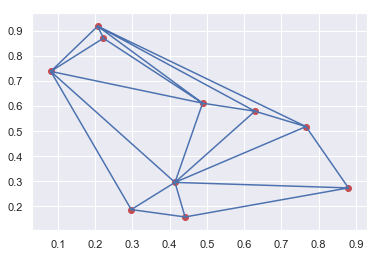

In [7]:
# How to compute delaunay triangulation (random points)
np.random.seed(seed=5)
from scipy.spatial import Delaunay
points = np.random.rand(10,2)
tri = Delaunay(points)
plt.scatter(points[:,0], points[:,1], c='r')
plt.triplot(points[:,0], points[:,1], tri.simplices.copy())
#points

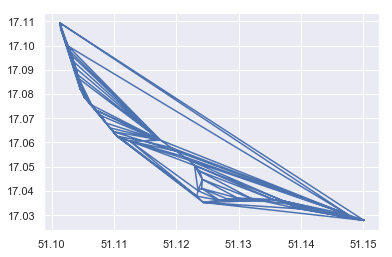

In [8]:
# How to compute delaunay triangulation (route points)
# does not work well on route, because many skinny triangles
# Idea: remove skinny triangles (future work)
tri = Delaunay(centers)
plt.triplot(centers[:,0], centers[:,1], tri.simplices.copy())

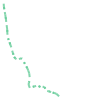

In [9]:
# How to find neighbors in O(n^2)
def get_neighbors(points):
    for i, point in enumerate(points):
        search = np.delete(centers, i, 0)
        nn = min(search, key=lambda candidate: great_circle(point, candidate).m)
        yield point, nn

MultiLineString(list(get_neighbors(centers)))

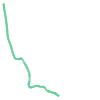

In [10]:
# How to find neighbors in O(n log(n))
from scipy import spatial

# Find neighbors approach (kd tree)
def get_neighbors(points):
    tree = spatial.KDTree(points)
    for i, point in enumerate(points):
        dists, js = tree.query(point, k=3)
        for dist, j in zip(dists, js):
            # drop self-match
            if dist > 0:
                yield point, points[j]

lines = [LineString(x) for x in get_neighbors(centers)]

MultiLineString(lines)
# Problem: has duplicates

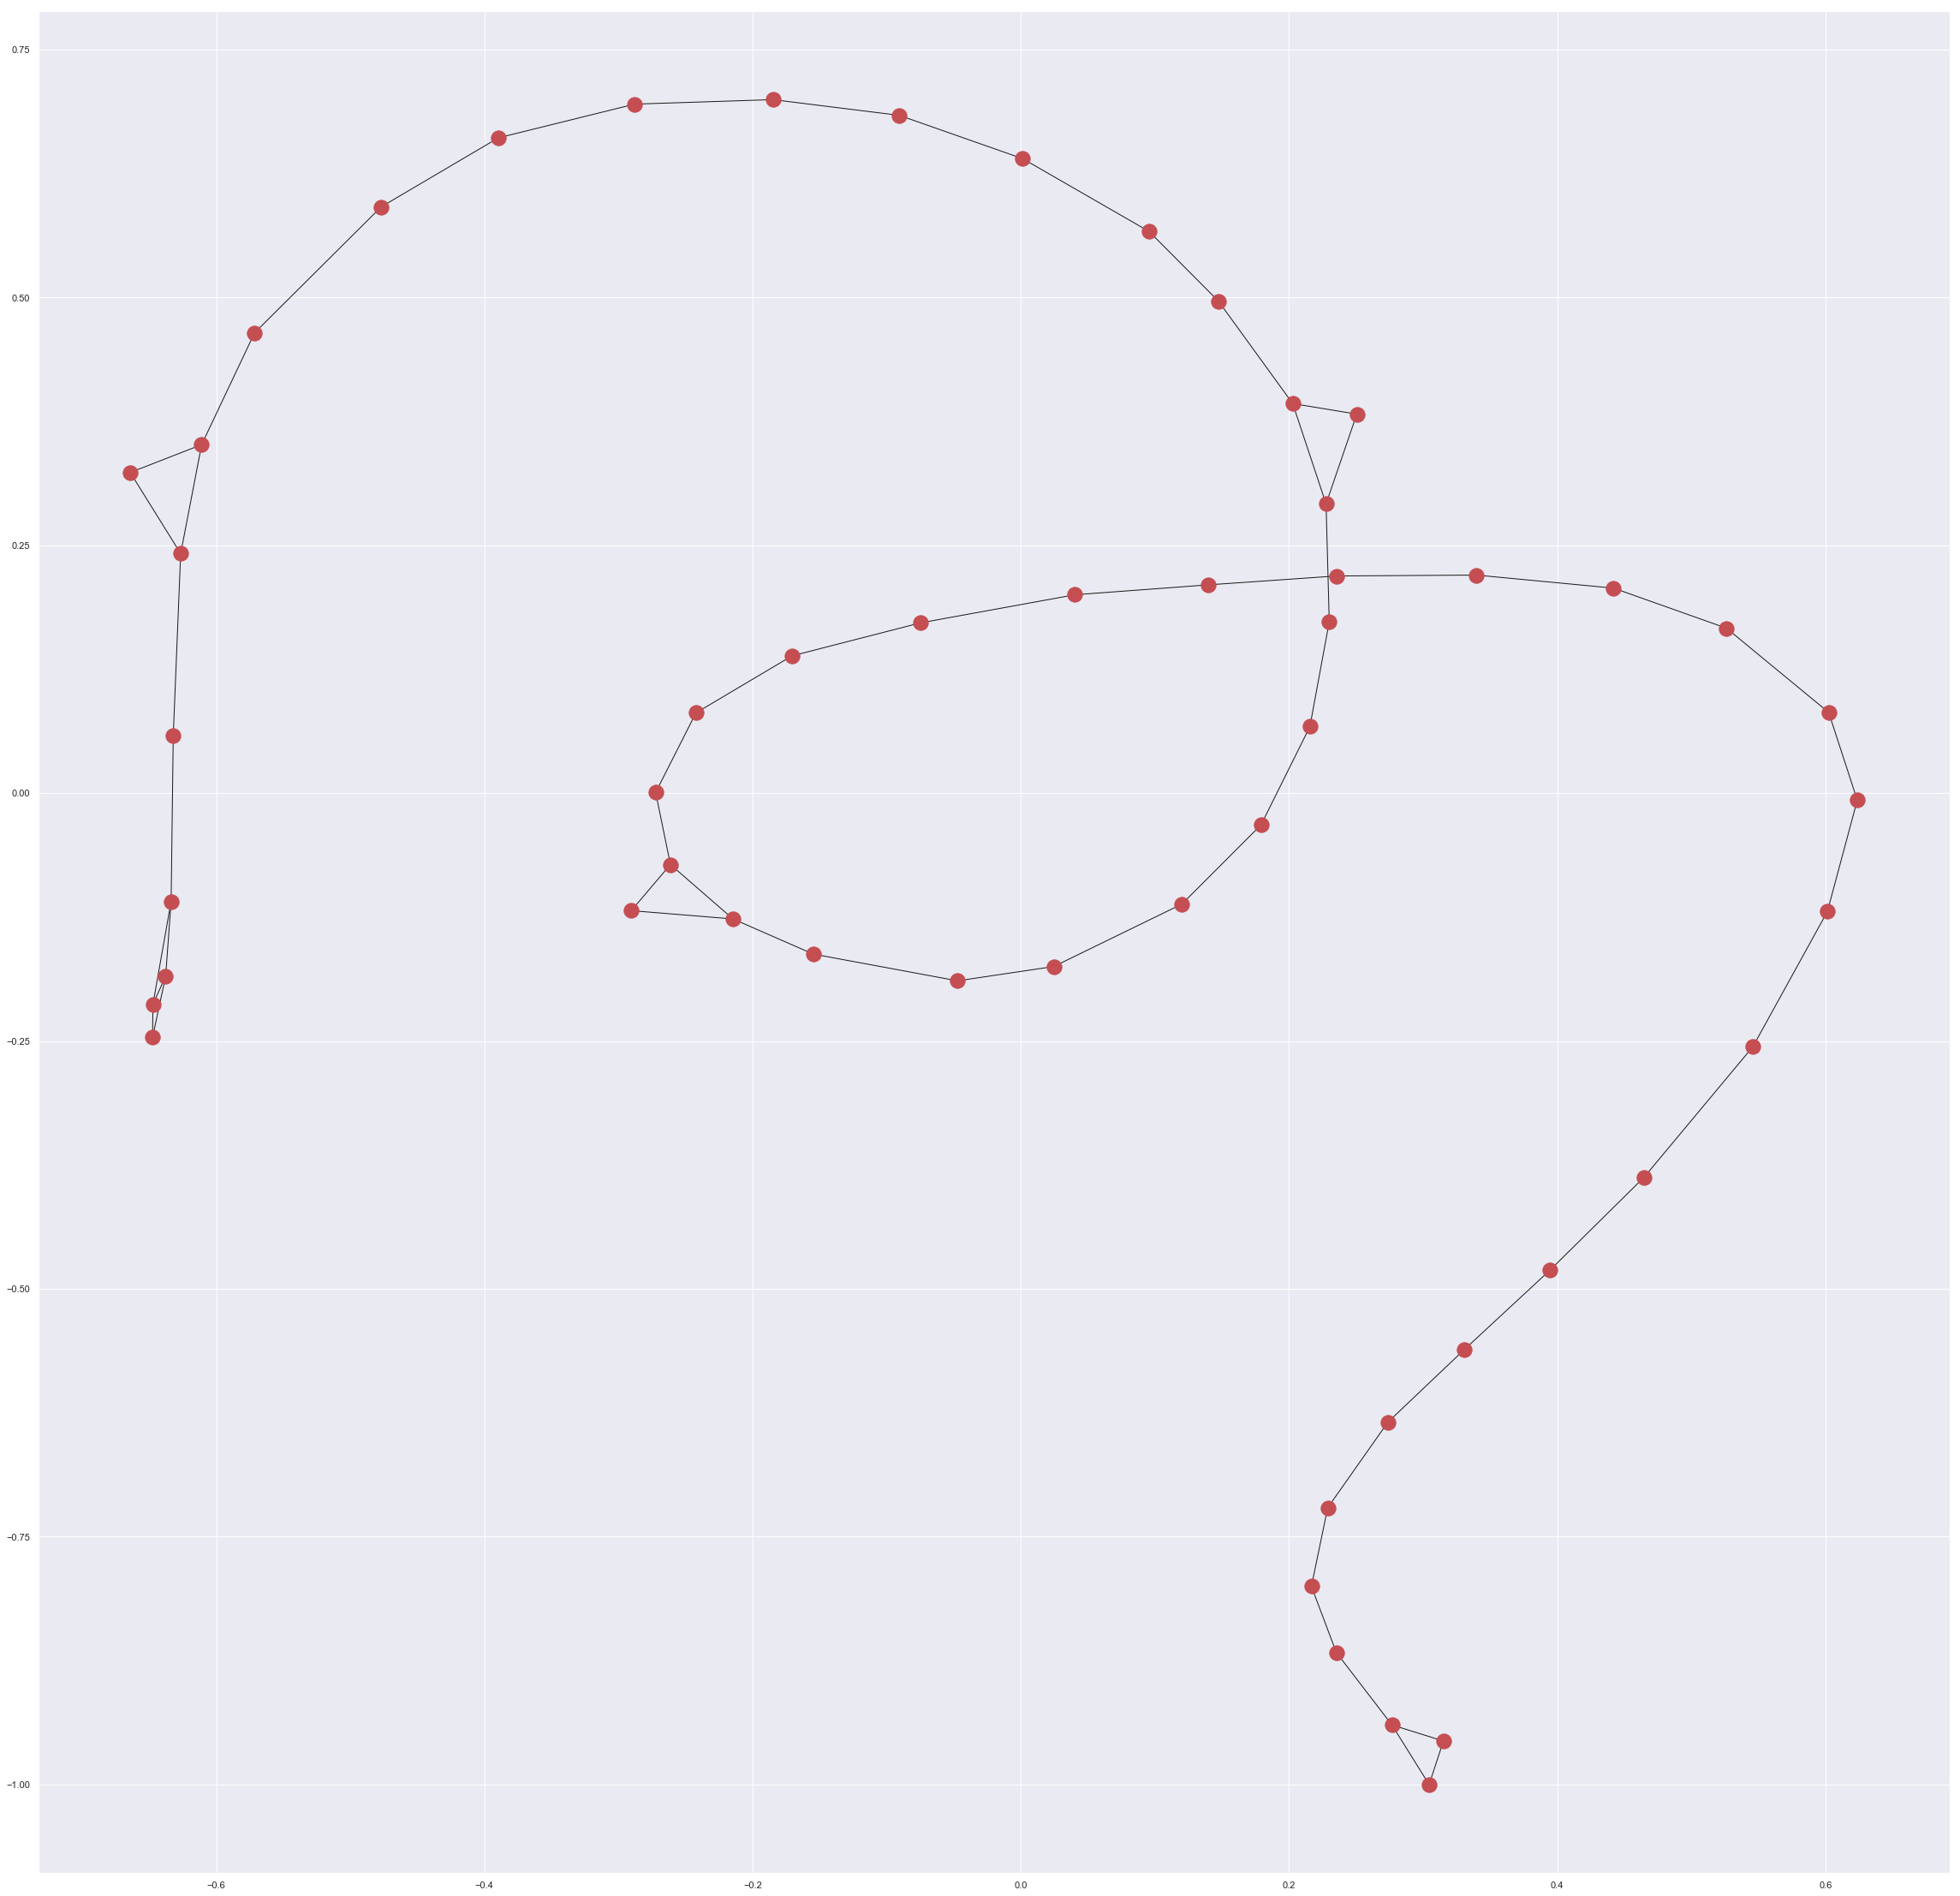

In [11]:
# How to connect neighbors in O(n log(n))
import networkx as nx
#https://networkx.github.io/documentation/networkx-1.10/reference/generated/networkx.Graph.add_weighted_edges_from.html#networkx.Graph.add_weighted_edges_from
#https://ipython-books.github.io/64-visualizing-a-networkx-graph-in-the-notebook-with-d3js/
K = 3
def get_edges(points):
    tree = spatial.KDTree(points)
    for i, point in enumerate(points):
        dists, js = tree.query(point, k=K)
        for dist, j in zip(dists, js):
            # drop self-match
            neighbor = points[j]
            dist = great_circle(point, neighbor).m
            if dist > 0:
                node1 = Point(point).to_wkt()
                node2 = Point(neighbor).to_wkt()
                yield node1, node2, dist

G = nx.Graph()
G.add_weighted_edges_from(get_edges(centers))
#G.edges(data=True)
fig, ax = plt.subplots(1, 1, figsize=(40, 40));
nx.draw_networkx(G, ax=ax, with_labels=False)
# Shortest path in this one should work reasonably well

In [14]:
# How to compute the distance in meters between to points on Earth
great_circle([12.5, 55.0], [11.5, 55.0]).m

111195.08372419146